# DMRG solution

For this task we will be constructing an DMRG-based solution to the UDMIS problem. This we will effectively be another classical approach, but using tools from tensor networks and condensed matter physics.

Firstly, we construct a matrix product operator of the Hamiltonian
$$
H = -\sum_{i\in V} \hat n_i + u \sum_{(i,j)\in E}\hat n_i \hat n_j
$$
by re-expressing it as a Pauli Hamiltonian. *(This isn't necessary but we are reusing some of our code for generating local Pauli Hamilonians)*

We instead have
$$
H = -\sum_{i\in V}\frac12 (I-Z_i) + \sum_{(i,j)\in E} \frac{u}{4} (I - Z_I - Z_j + Z_i Z_j)
$$
Once we have the Hamiltonian in the form of an MPO we can use DMRG to find the ground state (an MPS) which will be the solution to our problem. This will allow us to scale this approach to hig dimensions (large graphs) without hitting intractable demands on memory.

This is also true with the classical annealing approach as the state is modelled as a product state in the computational basis. The benefit here would be using the MPO to potentially inject noise into the system and simulate how the annealing with Rydberg atom arrays might perform in the presence of different unitary noise models.

Moreover, we have constructed our MPO out of a local Pauli Hamiltonian which is not optimal in bond dimension. We compress it after the fact using the s
This product is still an MVP, however, and these improvements will be made to our product in an upcoming release!

First, lets use the DMRG solution for the previous task to be sure it does what we expect.

In [56]:
from src.local import *
from src.udmis import *
from matplotlib import gridspec
from copy import deepcopy

import matplotlib.pyplot as plt

In [57]:
u = 1.35
graph = [
    (0.3461717838632017, 1.4984640297338632),
    (0.6316400411846113, 2.5754677320579895),
    (1.3906262250927481, 2.164978861396621),
    (0.66436005100802, 0.6717919819739032),
    (0.8663329771713457, 3.3876341010035995),
    (1.1643107343501296, 1.0823066243402013)
]

In [58]:
udmis = MPOClassicalUDMIS(u, graph)
udmis.hamiltonian

Local Hamiltonian Object:
Nsites:		6
Locality:	6

See now, with no pre-ordering on our graph we end up with some high weight non-local terms (up weight 6) in the Hamiltonian. This is simply due to the defined sites of each node being poorly chosen. Let's do a simple heuristic sort on their distance from the coordinate `(0,0)`

In [59]:
locality = []
for ci in udmis.hamiltonian.c:
    locality.append(len(ci[1]))

In [60]:
# Let's do a simple heuristic sort these nodes to give something more local
graph = sorted(graph, key=lambda g: np.linalg.norm(g))

In [61]:
udmis = MPOClassicalUDMIS(u, graph)
udmis.hamiltonian

Local Hamiltonian Object:
Nsites:		6
Locality:	3

Now we have a max weight of `3` in the Hamiltonian, which will significantly reduce the bond-dimension of the MPO

In [62]:
locality_opt = []
for ci in udmis.hamiltonian.c:
    locality_opt.append(len(ci[1]))

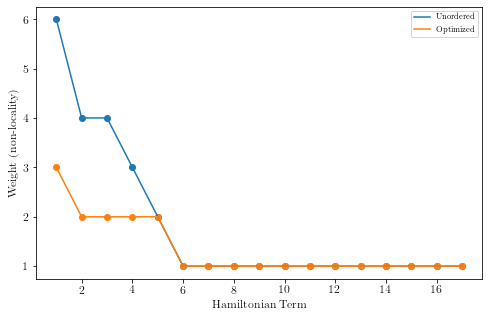

In [63]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,len(locality)+1), sorted(locality, reverse=True), label="Unordered")
ax.scatter(range(1,len(locality)+1), sorted(locality, reverse=True))
ax.plot(range(1,len(locality)+1), sorted(locality_opt, reverse=True), label="Optimized")
ax.scatter(range(1,len(locality)+1), sorted(locality_opt, reverse=True))
ax.set_xlabel("Hamiltonian Term")
ax.set_ylabel("Weight (non-locality)")
ax.legend()
plt.show()

In [64]:
H = udmis.hamiltonian
H

Local Hamiltonian Object:
Nsites:		6
Locality:	3

In [65]:
H = udmis.hamiltonian

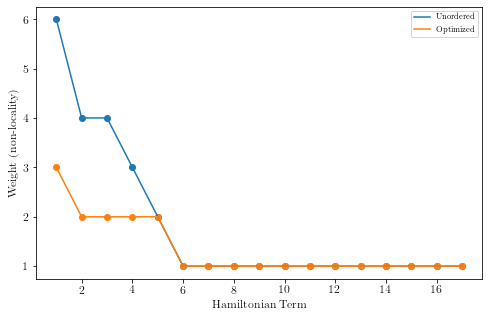

In [66]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,len(locality)+1), sorted(locality, reverse=True), label="Unordered")
ax.scatter(range(1,len(locality)+1), sorted(locality, reverse=True))
ax.plot(range(1,len(locality)+1), sorted(locality_opt, reverse=True), label="Optimized")
ax.scatter(range(1,len(locality)+1), sorted(locality_opt, reverse=True))
ax.set_xlabel("Hamiltonian Term")
ax.set_ylabel("Weight (non-locality)")
ax.legend()
plt.show()

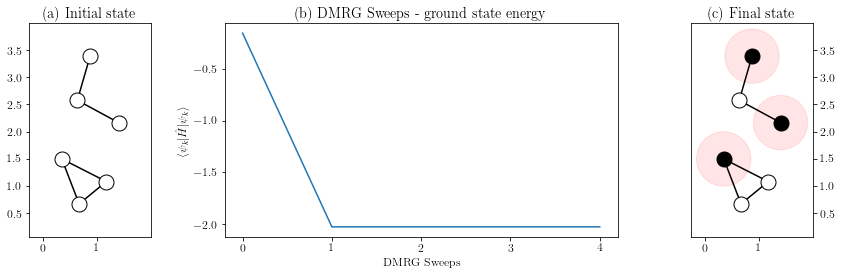

In [67]:
from src.figures import *

fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot2grid((1, 4), (0, 0))
ax2 = plt.subplot2grid((1, 4), (0, 1), colspan=2)
ax3 = plt.subplot2grid((1, 4), (0, 3))

plot_mpo_initial(ax1, udmis)
plot_mpo_sweeps(ax2, udmis)
plot_mpo_udmis(ax3, udmis)

ax1.set_title(r'(a) Initial state')
ax2.set_title(r'(b) DMRG Sweeps - ground state energy')
ax3.set_title(r'(c) Final state')
ax3.yaxis.tick_right()

fig.tight_layout()

# plt.savefig('../fig/classical_annealing_schedule_3.pdf')

Great! We get the same result using the DMRG approach as we did with the classical annealing

# Gotham City

Shown below is the cell-tower array in Gotham City. We need to find the UDMIS solution to determine the max independent set of towers that we can turn on without them overlapping.

In [68]:
graph = [(1.19, 4.25),
         (2.71, 3.48),
         (1.19, 3.51),
         (2, 3.38),
         (1.12, 2.86),
         (1.70, 2.42),
         (2.36, 2.54),
         (1.52, 1.48),
         (2.15, 1.54),
         (2.14, 1.87),
         (1.72, 0.86),
         (2.29, 0.87)]

In [69]:
# Let's do a simple heuristic sort these nodes to give something more local again
graph = sorted(graph, key=lambda g: np.linalg.norm(g))
udmis = MPOClassicalUDMIS(u, graph)
udmis.hamiltonian

Local Hamiltonian Object:
Nsites:		12
Locality:	5

/home/tim/Github/CohortProject_2021/Week2_Rydberg_Atoms/src/figures.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/tim/Github/CohortProject_2021/Week2_Rydberg_Atoms/src/figures.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/tim/Github/CohortProject_2021/Week2_Rydberg_Atoms/src/figures.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/tim/Github/CohortProject_2021/Week2_Rydberg_Atoms/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


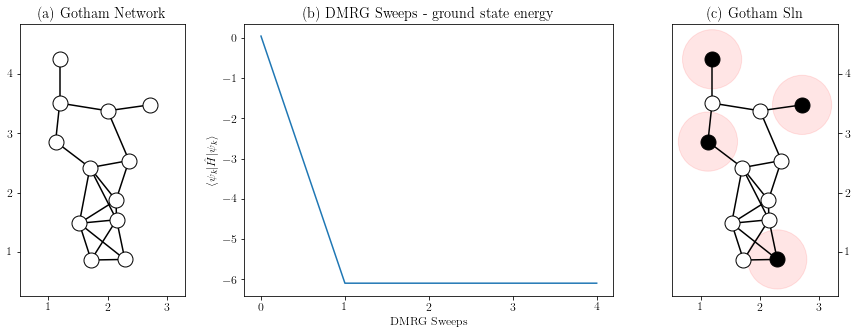

In [70]:
from src.figures import *

fig = plt.figure(figsize=(15, 5))

gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1,2,1], height_ratios=[1], wspace=0.2)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

plot_mpo_initial(ax1, udmis)
plot_mpo_sweeps(ax2, udmis)
plot_mpo_udmis(ax3, udmis)

ax1.set_title(r'(a) Gotham Network')
ax2.set_title(r'(b) DMRG Sweeps - ground state energy')
ax3.set_title(r'(c) Gotham Sln')
ax3.yaxis.tick_right()

fig.tight_layout()
plt.savefig('../fig/dmrg_solution_gotham.pdf')

Note how with a single sweep DMRG has, for all intents and purposes, converged to the ground state! Such a powerful method. 

There is a problem with this solution, however! The ground state doesn't quite converge to the same one we get from the classical annealing

# Gotham City - Classical annealing

Shown below is the cell-tower array in Gotham City. We need to find the UDMIS solution to determine the max independent set of towers that we can turn on without them overlapping.

In [74]:
# Let's do a simple heuristic sort these nodes to give something more local again
udmis = ClassicalUDMIS(u, graph)

In [75]:
udmis_init = deepcopy(udmis)
num_steps = 5000

T_i = 100
T_f = 0.01

temperature, energy = [], []
for n in range(num_steps):
    T = T_i * ((T_f/T_i) ** (n/num_steps))
    # T = T_i * ((T_f/T_i) ** (n/num_steps)) * 0.1 * np.sqrt(n)
    # T = T_i * ((T_f/T_i) ** ((n/num_steps) ** 2))
    # T = T_i * ((T_f/T_i) ** ((n/num_steps) ** 0.5))
    E = udmis.monte_carlo_step(T)
    if n % 100 == 0:
        temperature.append(T)
        energy.append(E)
    # print(n, E, udmis.occupations)

/home/tim/Github/CohortProject_2021/Week2_Rydberg_Atoms/src/figures.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/tim/Github/CohortProject_2021/Week2_Rydberg_Atoms/env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


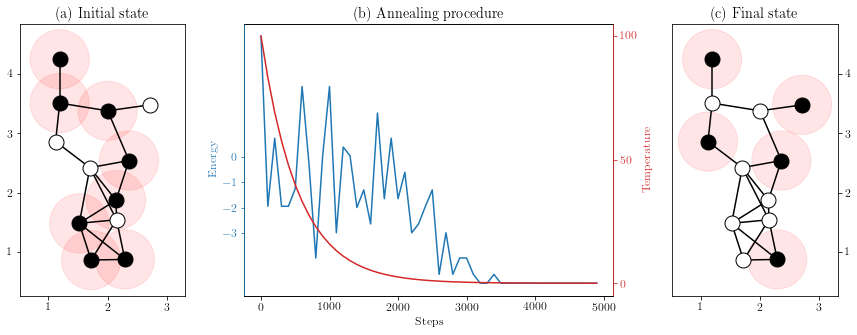

In [76]:
from src.figures import *

fig = plt.figure(figsize=(15, 5))

gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1,2,1], height_ratios=[1], wspace=0.2)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

plot_classical_udmis(ax1, udmis_init)
plot_classical_annealing(ax2, np.arange(0, num_steps, 100), energy, temperature)
plot_classical_udmis(ax3, udmis)

ax1.set_title(r'(a) Initial state')
ax2.set_title(r'(b) Annealing procedure')
ax3.set_title(r'(c) Final state')
ax3.yaxis.tick_right()

fig.tight_layout()
plt.savefig('../fig/dmrg_solution_gotham.pdf')

There is one extra node lit up using this approach, which visually almost looks like they overlap. However this is not the case as we see:

In [88]:
print("Distance between node 7 and 10: {:.3f}".format(np.linalg.norm(np.array(graph[10])-np.array(graph[7]))))

Distance between node 7 and 10: 1.003
